### Creating Model 1

* Creating a 1st model for the NFL Play data. The goal is to predict the play type on 4th down.
* Random Forest and gradient boosted trees are the other models

In [1]:
from pyspark.ml import Pipeline  
from pyspark.ml.feature import *  
from pyspark.ml.classification import RandomForestClassifier
import nfl_data_py as nfl
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTENC
import pandas as pd
from imblearn.combine import SMOTEENN
from DataPipelineFxn import *
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

SyntaxError: invalid syntax (_metadata_requests.py, line 1512)

In [3]:
# get the spark session and data frame
data = GetSparkDF(end_year = 2023, include_undersample = True)

2000 done.
2001 done.
2002 done.
2003 done.
2004 done.
2005 done.
2006 done.
2007 done.
2008 done.
2009 done.
2010 done.
2011 done.
2012 done.
2013 done.
2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.


/opt/conda/lib/python3.7/site-packages/pyspark/bin/load-spark-env.sh: line 68: ps: command not found
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


24/12/04 13:37:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/12/04 13:37:54 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
24/12/04 13:37:55 WARN TaskSetManager: Stage 0 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.


24/12/04 13:37:57 WARN TaskSetManager: Stage 3 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.


24/12/04 13:38:04 WARN TaskSetManager: Stage 4 contains a task of very large size (3171 KiB). The maximum recommended task size is 1000 KiB.


24/12/04 13:38:08 WARN TaskSetManager: Stage 5 contains a task of very large size (1930 KiB). The maximum recommended task size is 1000 KiB.


In [4]:
spark, df, test_df, undersample_df = data

In [5]:
# get 2023 season data that was withheld to use as another test set
test_df_2023 = get_2023_season_test_df()

2023 done.


In [6]:
df = df.drop('season')
test_df_2023 = test_df_2023.drop('season')

### Create numeric columns list for the pipeline

In [7]:
numeric_cols = []
for field in df.schema.fields:
    if str(field.dataType) != "StringType()":
        numeric_cols.append(field.name)
        
#numeric_cols.remove("season")
numeric_cols.remove("week")

In [6]:
print(numeric_cols)

['yardline_100', 'quarter_seconds_remaining', 'half_seconds_remaining', 'game_seconds_remaining', 'down', 'drive', 'qtr', 'ydstogo', 'posteam_timeouts_remaining', 'defteam_timeouts_remaining', 'posteam_score', 'defteam_score', 'score_differential', 'ep', 'epa', 'wind', 'temp']


### Create the Model Pipeline

In [8]:
spark.sparkContext.setLogLevel("ERROR")
str_col = ["home_team", "away_team", "season_type", "posteam", "posteam_type", "defteam", "side_of_field", "game_half", "week",
        "play_type", 'roof', 'surface']
str_col_output = ["home_team_idx", "away_team_idx", "season_type_idx", "posteam_idx", "posteam_type_idx", "defteam_idx", "week_idx",
                  "side_of_field_idx", "game_half_idx", "play_type_idx", 'roof_idx', 'surface_idx']
ohe_col_input = ["home_team_idx", "away_team_idx", "season_type_idx", "posteam_idx", "posteam_type_idx", "defteam_idx", "week_idx",
                  "side_of_field_idx", "game_half_idx", 'roof_idx', 'surface_idx']
ohe_col_vec = ["home_team_vec", "away_team_vec", "season_type_vec", "posteam_vec", "posteam_type_vec", "defteam_vec", "week_vec",
                  "side_of_field_vec", "game_half_ivec", 'roof_vec', 'surface_vec']

# Combine numeric and one-hot encoded columns
va_input_cols = numeric_cols + ohe_col_vec

# process using string indexer first for catgeorical features  
stringIndexer = StringIndexer(inputCols=str_col, outputCols=str_col_output)

# process rating data into second feature
ohe = OneHotEncoder(inputCols=ohe_col_input, outputCols=ohe_col_vec) 


# Assemble features column
va = VectorAssembler(inputCols=va_input_cols, outputCol="features", handleInvalid = "skip")

# process data using maxabs scaler, not necessarily important for trees but consistency
scaler = MaxAbsScaler(inputCol="features", outputCol="scaledFeatures")

# define the model

#spark.conf.set("spark.speculation", "false")
# Use Random Forest Classifier
rf = RandomForestClassifier(labelCol='play_type_idx', 
                             featuresCol='scaledFeatures', 
                             seed=42)


# Fit the pipeline
pipeline = Pipeline(stages=[stringIndexer, ohe, va, scaler, rf])

In [9]:

# Set up hyperparameter tuning
paramGrid = ParamGridBuilder()\
    .addGrid(rf.numTrees, [10, 50, 100])\
    .addGrid(rf.maxDepth, [5, 10, 15])\
    .addGrid(rf.impurity, ["gini", "entropy"])\
    .build()


# build the evaluator
evaluator = MulticlassClassificationEvaluator(
    predictionCol="prediction",
    labelCol="play_type_idx",
    metricName="accuracy"
)

# set up the train validation split
tvs = TrainValidationSplit(
    estimator=pipeline,
    evaluator=evaluator,
    estimatorParamMaps=paramGrid,
    # 80% of the data will be used for training, 20% for validation.
    trainRatio=0.8
)

In [9]:
df.select(df.roof).distinct().show()

+--------+
|    roof|
+--------+
|outdoors|
|  closed|
|    open|
|    dome|
+--------+



In [10]:
# need to replace the empty string in surface
df = df.withColumn(
    'surface',
    F.when(df.surface == '', 'Undefined').otherwise(df.surface)
)

# fit the model with the hyperparameter search
rf_model = tvs.fit(df)

### Evaluate the Model

In [11]:
best_model = rf_model.bestModel

# Extract the parameter map of the best model
best_params = best_model.stages[-1].extractParamMap()

# Print the parameters values
print("Tuned Parameters of the Best Model:")
for param, value in best_params.items():
    print(f"{param.name}: {value}")

Tuned Parameters of the Best Model:
bootstrap: True
cacheNodeIds: False
checkpointInterval: 10
featureSubsetStrategy: auto
featuresCol: scaledFeatures
impurity: entropy
labelCol: play_type_idx
leafCol: 
maxBins: 32
maxDepth: 15
maxMemoryInMB: 256
minInfoGain: 0.0
minInstancesPerNode: 1
minWeightFractionPerNode: 0.0
numTrees: 100
predictionCol: prediction
probabilityCol: probability
rawPredictionCol: rawPrediction
seed: 42
subsamplingRate: 1.0


In [12]:
# have to change test df instance
test_df = test_df.withColumn(
    'surface',
    F.when(test_df.surface == '', 'Undefined').otherwise(test_df.surface)
)

test_df_2023 = test_df_2023.withColumn(
    'surface',
    F.when(test_df_2023.surface == '', 'Undefined').otherwise(test_df_2023.surface)
)

prediction = best_model.transform(test_df)
prediction2 = best_model.transform(test_df_2023)

In [14]:
f1_evaluator = MulticlassClassificationEvaluator(
    labelCol='play_type_idx', predictionCol="prediction",
    metricName='f1'
)

accuracy_evaluator = MulticlassClassificationEvaluator(
    labelCol='play_type_idx', predictionCol="prediction",
    metricName='accuracy'
)

precision_by_label_eval = MulticlassClassificationEvaluator(
    labelCol='play_type_idx', predictionCol="prediction",
    metricName='precisionByLabel'
)

weighted_precision_eval = MulticlassClassificationEvaluator(
    labelCol='play_type_idx', predictionCol="prediction",
    metricName='weightedPrecision'
)


weighted_recall_eval = MulticlassClassificationEvaluator(
    labelCol='play_type_idx', predictionCol="prediction",
    metricName='weightedRecall'
)

f1_score = f1_evaluator.evaluate(prediction2)
accuracy = accuracy_evaluator.evaluate(prediction2)
precision_by_label = precision_by_label_eval.evaluate(prediction2)
precision = weighted_precision_eval.evaluate(prediction2)
recall = weighted_recall_eval.evaluate(prediction2)

results = f'''
F1: {f1_score}
Accuracy: {accuracy}
Precision by Label: {precision_by_label}
Weighted Precision: {precision}
Weighted Recall: {recall}
'''

print(results)


F1: 0.803098088684291
Accuracy: 0.8396188963874553
Precision by Label: 0.8561643835616438
Weighted Precision: 0.7845669538481281
Weighted Recall: 0.8396188963874553



In [55]:
from pyspark.sql.functions import round
prediction.select([prediction.home_team, prediction.posteam, prediction.defteam, prediction.posteam_score, prediction.defteam_score, prediction.yardline_100, prediction.side_of_field, prediction.ydstogo, \
                   round(prediction.quarter_seconds_remaining/60,2).alias("quarter min remaining"), prediction.qtr,prediction.play_type_idx, prediction.play_type, prediction.season ,prediction.prediction]) \
    .where((prediction.posteam=="BAL") & (prediction.season=='2023')).toPandas().to_csv('mycsv.csv')

In [18]:
from pyspark.sql.functions import round
prediction2.select([prediction2.home_team, prediction2.posteam, prediction2.defteam, prediction2.posteam_score, prediction2.defteam_score, prediction2.yardline_100, prediction2.side_of_field, prediction2.ydstogo, \
                   round(prediction2.quarter_seconds_remaining/60,2).alias("quarter min remaining"), prediction2.qtr,prediction2.play_type_idx, prediction2.play_type ,prediction2.prediction]) \
    .where((prediction2.posteam=="BAL")  & (prediction2.play_type_idx != prediction2.prediction)).show(20)

+---------+-------+-------+-------------+-------------+------------+-------------+-------+---------------------+---+-------------+----------+----------+
|home_team|posteam|defteam|posteam_score|defteam_score|yardline_100|side_of_field|ydstogo|quarter min remaining|qtr|play_type_idx| play_type|prediction|
+---------+-------+-------+-------------+-------------+------------+-------------+-------+---------------------+---+-------------+----------+----------+
|      BAL|    BAL|    IND|         19.0|         19.0|        43.0|          IND|    2.0|                  0.1|4.0|          1.0|field_goal|       2.0|
|      BAL|    BAL|    IND|         19.0|         19.0|        47.0|          IND|    3.0|                 3.42|5.0|          2.0|      pass|       0.0|
|      CLE|    BAL|    CLE|         28.0|          3.0|        63.0|          BAL|    8.0|                 2.37|4.0|          4.0|   no_play|       0.0|
|      PIT|    BAL|    PIT|         10.0|          3.0|        23.0|          PIT|

In [ ]:
prediction2.groupby(prediction2.prediction).count().show()

In [49]:
prediction2.select(prediction2.play_type, prediction2.play_type_idx).groupby([prediction2.play_type,prediction2.play_type_idx]).count().show()

+----------+-------------+-----+
| play_type|play_type_idx|count|
+----------+-------------+-----+
|      punt|          0.0|26153|
|   no_play|          4.0| 1371|
|field_goal|          1.0| 6343|
|       run|          3.0| 1447|
|      pass|          2.0| 2360|
+----------+-------------+-----+



In [46]:
prediction.groupby(prediction.play_type_idx).count().show()

+-------------+-----+
|play_type_idx|count|
+-------------+-----+
|          0.0|26153|
|          1.0| 6343|
|          4.0| 1371|
|          3.0| 1447|
|          2.0| 2360|
+-------------+-----+



In [21]:
labels = prediction2.select([prediction2.play_type, prediction2.play_type_idx]).distinct().orderBy(prediction2.play_type_idx).select(prediction2.play_type).collect()
labels = [x[0] for x in labels]

In [ ]:
test_df.groupby(test_df.play_type).count().show()

In [15]:
results = f'''
F1: {f1_score}
Accuracy: {accuracy}
Precision by Label: {precision_by_label}
Weighted Precision: {precision}
Weighted Recall: {recall}
'''

print(results)


F1: 0.8846651793816552
Accuracy: 0.9063810585549716
Precision by Label: 0.9408236705317873
Weighted Precision: 0.8885594820638866
Weighted Recall: 0.9063810585549714



In [19]:
from pyspark.sql.types import FloatType
from pyspark.mllib.evaluation import MulticlassMetrics

#Adapting code from https://www.kaggle.com/code/ashokkumarpalivela/multiclass-classification-using-pyspark for confusion matrix
preds_and_labels = prediction2.select(['prediction','play_type_idx'])\
                              .withColumn('play_type_idx', col('play_type_idx')\
                              .cast(FloatType()))\
                              .orderBy('play_type_idx')
    
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

print(metrics.confusionMatrix().toArray())

/opt/conda/lib/python3.7/site-packages/pyspark/sql/context.py:159: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning,


[[1.375e+03 0.000e+00 1.000e+00 0.000e+00 0.000e+00]
 [2.100e+01 5.270e+02 7.000e+00 0.000e+00 0.000e+00]
 [6.600e+01 5.400e+01 1.310e+02 2.600e+01 0.000e+00]
 [4.600e+01 2.100e+01 1.800e+01 8.200e+01 0.000e+00]
 [9.800e+01 2.500e+01 1.200e+01 9.000e+00 0.000e+00]]


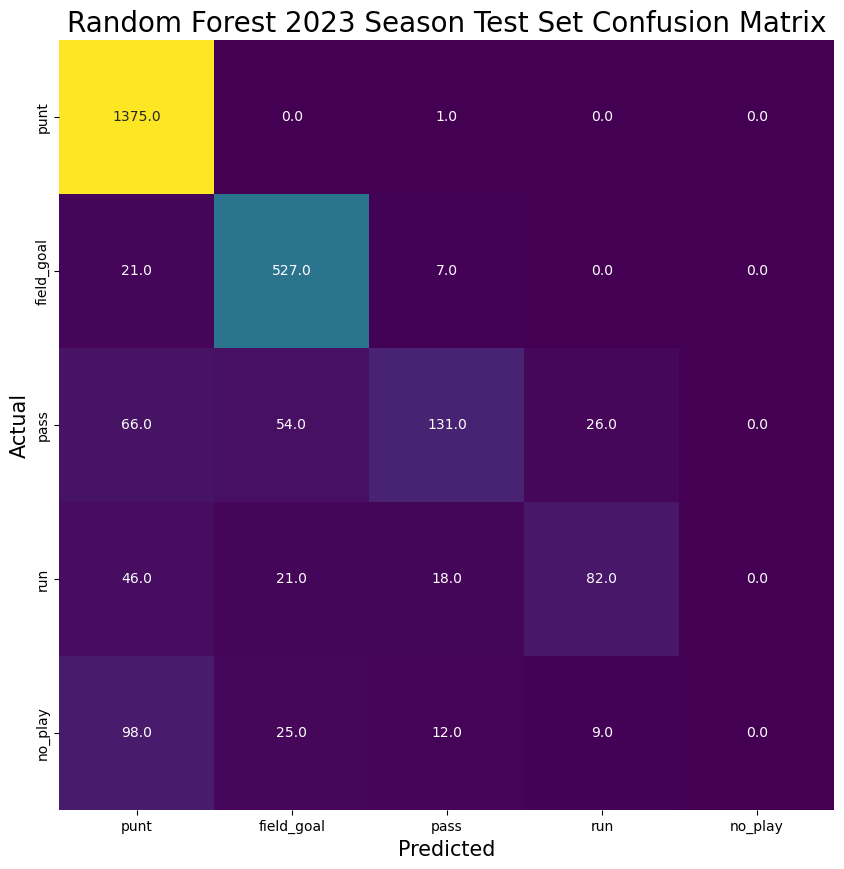

In [24]:
_ = plt.figure(figsize=(10, 10))
ax = sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels,
            yticklabels=labels)

plt.title('Random Forest 2023 Season Test Set Confusion Matrix', fontsize = 20) # title with fontsize 20
plt.xlabel('Predicted', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('Actual', fontsize = 15) # y-axis label with fontsize 15
plt.savefig('rf2023-normal-confusion-matrix.png')

### Conclusions

Some quick observations:

* Much better performance when we don't undersample, could be because everything is a punt
* We need to be careful with the labels for the confusion matrix. They were not intially lining up properly with what the idxs are.
* I added temp, wind, roof, surface to the predictors